# Residual Networks

You'll be building a very deep convolutional network, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously feasible.

**By the end of this assignment, you'll be able to:**

- Implement the basic building blocks of ResNets in a deep neural network using PyTorch
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification
- Implement a skip connection in your network

For this assignment, you'll use PyTorch.

Before jumping into the problem, run the cell below to load the required packages.

First we will need to download some external resources from GitHub. Run the cell below.

In [1]:
!git clone https://github.com/tcuseniordesign/deep-learning-hw7-1.git

Cloning into 'deep-learning-hw7-1'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 0), reused 19 (delta 0), pack-reused 0
Receiving objects: 100% (19/19), 10.49 MiB | 7.24 MiB/s, done.


Then we need to move the resources to the current directory. Run the cell below.

In [2]:
import shutil
import os

source_dir = '/content/deep-learning-hw7-1'
target_dir = '/content'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

os.rmdir('/content/deep-learning-hw7-1')

## Table of Content

- [1 - Packages](#1)
- [2 - The Problem of Very Deep Neural Networks](#2)
- [3 - Building a Residual Network](#3)
    - [3.1 - The Identity Block](#3-1)
        - [Exercise 1 - identity_block](#ex-1)
    - [3.2 - The Convolutional Block](#3-2)
        - [Exercise 2 - convolutional_block](#ex-2)
- [4 - Building Your First ResNet Model (50 layers)](#4)
    - [Exercise 3 - ResNet50](#ex-3)
- [5 - Bibliography](#5)

<a name='1'></a>
## 1 - Packages

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from resnets_utils import *

from torch.utils.data import DataLoader, sampler, TensorDataset

import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import h5py

<a name='2'></a>
## 2 - The Problem of Very Deep Neural Networks

In the last homework, you built your first convolutional neural networks: first manually with numpy, then using PyTorch.

In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output).

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

* More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values).

* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds, as shown below:

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw7-1/main/images/vanishing_grad.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Vanishing gradient</b> <br> The speed of learning decreases very rapidly for the shallower layers as the network trains </center></caption>

Don't worry! You are now going to solve this problem by building a Residual Network!

<a name='3'></a>
## 3 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw7-1/main/images/skip_connection.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : A ResNet block showing a skip-connection <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network.

The lecture mentioned that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

<a name='3-1'></a>
### 3.1 - The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw7-1/main/images/idblock2.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in PyTorch!

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this:

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw7-1/main/images/idblock3.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

These are the individual steps:

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random initialization.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random initialization.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random initialization.
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component.

Final step:
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- Then apply the ReLU activation function. This has no hyperparameters.

<a name='ex-1'></a>
### Exercise 1 - identity_block

Implement the ResNet identity block. The first component of the main path has been implemented for you already! First, you should read these docs carefully to make sure you understand what's happening. Then, implement the rest.
- To implement the Conv2D step: [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- To implement BatchNorm: [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- For the activation, use: [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

 Here is where you're actually using the power of the Functional API to create a shortcut path:

In [4]:
#identity block doesn't change input sizes and the number of channels.
class identity_block(nn.Module):
    def __init__(self, f, filters, in_channels):
        """
        Define components used in identity_block

        Arguments:
        f -- integer, specifying the shape of the middle CONV's window for the main path
        filters -- python list of integers, defining the number of filters in the CONV layers of the main path
        in_channels -- number of channels in the input image
        """
        super(identity_block, self).__init__()
        F1, F2, F3 = filters

        #First component of the main path
        self.conv2d_1 = nn.Conv2d(in_channels, F1, kernel_size=1) #doesn't change input size
        self.bn_1 = nn.BatchNorm2d(F1)
        self.relu_1 = nn.ReLU()

        ### START CODE HERE
        #Second component of the main path
        self.conv2d_2 = nn.Conv2d(F1, F2, kernel_size=f, padding="same")  # padding to maintain size
        self.bn_2 = nn.BatchNorm2d(F2)
        self.relu_2 = nn.ReLU()

        #Third component of the main path
        self.conv2d_3 = nn.Conv2d(F2, F3, kernel_size=1)  # doesn't change input size
        self.bn_3 = nn.BatchNorm2d(F3)

        ### END CODE HERE

        # Final ReLU layer
        self.relu_3 = nn.ReLU()

    def forward(self, x):
        x_shortcut = x

        # First component of main path
        x = self.conv2d_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)

        ### START CODE HERE
        ## Second component of main path (3 lines)
        x = self.conv2d_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)

        ## Third component of main path (2 lines)
        x = self.conv2d_3(x)
        x = self.bn_3(x)

        ### END CODE HERE

        ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
        x += x_shortcut
        x = self.relu_3(x)

        return x

<a name='3-2'></a>
### 3.2 - The Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw7-1/main/images/convblock.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.)
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.

The details of the convolutional block are as follows.

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component.

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".
- The BatchNorm is normalizing the 'channels' axis.

Final step:
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters.

<a name='ex-2'></a>    
### Exercise 2 - convolutional_block
    
Implement the convolutional block. The first component of the main path is already implemented; then it's your turn to implement the rest!
- To implement the Conv2D step: [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- To implement BatchNorm: [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- For the activation, use: [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

In [5]:
class convolutional_block(nn.Module):
    def __init__(self, f, filters, s, in_channels):
        """
        Define components used in identity_block

        Arguments:
        f -- integer, specifying the shape of the middle CONV's window for the main path
        filters -- python list of integers, defining the number of filters in the CONV layers of the main path
        in_channels -- number of channels in the input image
        s -- Integer, specifying the stride to be used
        """
        super(convolutional_block, self).__init__()

        F1, F2, F3 = filters

        #First component of the main path
        self.conv2d_1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=s)
        self.bn_1 = nn.BatchNorm2d(F1)
        self.relu_1 = nn.ReLU()

        #Second component of the main path
        ### START CODE HERE
        self.conv2d_2 = nn.Conv2d(F1, F2, kernel_size = f, stride=1, padding = "same")
        self.bn_2 = nn.BatchNorm2d(F2)
        self.relu_2 = nn.ReLU()

        #Third component of the main path
        self.conv2d_3 = nn.Conv2d(F2, F3, kernel_size=1)  # input size not changed
        self.bn_3 = nn.BatchNorm2d(F3)

        #Shortcut path
        self.conv_shortcut = nn.Conv2d(in_channels, F3, kernel_size=1, stride=s)  # Adjust dimensions using 1x1 conv
        self.bn_shortcut = nn.BatchNorm2d(F3)

        ### END CODE HERE

        # Final ReLU layer
        self.relu_3 = nn.ReLU()

    def forward(self, x):
        x_shortcut = x

        # First component of main path
        x = self.conv2d_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)

        ### START CODE HERE
        ## Second component of main path (≈3 lines)
        x = self.conv2d_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)

        ## Third component of main path (≈2 lines)
        x = self.conv2d_3(x)
        x = self.bn_3(x)

        ##### SHORTCUT PATH ##### (≈2 lines)
        x_shortcut = self.conv_shortcut(x_shortcut)
        x_shortcut = self.bn_shortcut(x_shortcut)


        ### END CODE HERE

        # Final step: Add shortcut value to main path, and pass it through a RELU activation
        x += x_shortcut
        x = self.relu_3(x)

        return x

<a name='4'></a>  
## 4 - Building Your First ResNet Model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw7-1/main/images/resnet.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

    
<a name='ex-3'></a>      
### Exercise 3 - ResNet50
    
Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2). Make sure you follow the naming convention in the text above.

You'll need to use this function:
- Average pooling [see reference](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)

Here are some other functions we used in the code below:
- To implement the Conv2D step: [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- To implement BatchNorm: [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- For the activation, use: [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Zero padding: [See reference](https://pytorch.org/docs/stable/generated/torch.nn.ZeroPad2d.html)
- Max pooling: [See reference](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- Fully connected layer: [See reference](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Click "Runetime", then click "Change runtime type". Select "GPU" for Hardware accelerator. You can compare the speed between "GPU" and "CPU".

In [6]:
num_classes = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
ResNet50 = nn.Sequential(
    nn.ZeroPad2d(3),

    #Stage 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=3, stride=2),

    #Stage 2
    convolutional_block(f=3, filters=[64, 64, 256], s=1, in_channels=64),
    identity_block(f=3, filters=[64, 64, 256], in_channels=256),
    identity_block(f=3, filters=[64, 64, 256], in_channels=256),

    ### START CODE HERE
    ## Stage 3 (≈4 lines)
    convolutional_block(f=3, filters=[128, 128, 512], s=2, in_channels=256),
    identity_block(f=3, filters=[128, 128, 512], in_channels=512),
    identity_block(f=3, filters=[128, 128, 512], in_channels=512),
    identity_block(f=3, filters=[128, 128, 512], in_channels=512),

    ## Stage 4 (≈6 lines)
    convolutional_block(f=3, filters=[256, 256, 1024], s=2, in_channels=512),
    identity_block(f=3, filters=[256, 256, 1024], in_channels=1024),
    identity_block(f=3, filters=[256, 256, 1024], in_channels=1024),
    identity_block(f=3, filters=[256, 256, 1024], in_channels=1024),
    identity_block(f=3, filters=[256, 256, 1024], in_channels=1024),
    identity_block(f=3, filters=[256, 256, 1024], in_channels=1024),

    ## Stage 5 (≈3 lines)
    convolutional_block(f=3, filters=[512, 512, 2048], s=2, in_channels=1024),
    identity_block(f=3, filters=[512, 512, 2048], in_channels=2048),
    identity_block(f=3, filters=[512, 512, 2048], in_channels=2048),

    ## AVGPOOL (≈1 line).
     nn.AvgPool2d((1, 1)),

    ### END CODE HERE

    # output layer
    nn.Flatten(),
    nn.Linear(2048, num_classes)
).to(device)

See the details of this model.

In [8]:
ResNet50

Sequential(
  (0): ZeroPad2d((3, 3, 3, 3))
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): convolutional_block(
    (conv2d_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU()
    (conv2d_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU()
    (conv2d_3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (bn_shortcut): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Define a loss function and an optimizer.

In [9]:
#Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet50.parameters(), lr=1e-3)

The model is now ready to be trained. The only thing you need is a dataset.

Let's load your old friend, the SIGNS dataset.

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw7-1/main/images/signs_data.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 6</b> </u><font color='purple'>  : <b>SIGNS dataset</b> </center></caption>


In [10]:
# Loading the data (signs)
X_train_orig, Y_train, X_test_orig, Y_test, classes = load_dataset()

#swap axes to make them usable by PyTorch
X_train_orig = np.transpose(X_train_orig, (0, 3, 1, 2))
X_test_orig = np.transpose(X_test_orig, (0, 3, 1, 2))

Y_train = Y_train.ravel() # If CrossEntropy loss is used, the target/ground truth can be the label value (0 - 5). No need to convert to one-hot encoding.
Y_test = Y_test.ravel()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 3, 64, 64)
Y_train shape: (1080,)
X_test shape: (120, 3, 64, 64)
Y_test shape: (120,)


In [11]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

X_train_tensor = torch.from_numpy(X_train).type(torch.float)
Y_train_tensor = torch.from_numpy(Y_train).type(torch.LongTensor)

X_test_tensor = torch.from_numpy(X_test).type(torch.float)
Y_test_tensor = torch.from_numpy(Y_test).type(torch.LongTensor)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Run the following cell to train your model on 2 epochs with a batch size of 32. On a GPU, it should take less than 2 minutes.

In [12]:
# Calculate accuracy (a classification metric)
def accuracy(y_true, y_pred_logits):
    correct = torch.eq(y_true, y_pred_logits.argmax(dim=1)).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred_logits)) * 100
    return acc

In [13]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

Time to launch training!

In [14]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (Make sure you use GPU, otherwise it will be very slow)
epochs = 10

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss, train_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        ResNet50.train()
        # 1. Forward pass
        y_logits = ResNet50(X)
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_logits, y) # y_logits is (35, 6) and y is (32,)
        train_loss += loss # accumulatively add up the loss per epoch

        train_acc += accuracy(y_true=y,
                                y_pred_logits=y_logits)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 10 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss and train accuray by length of train dataloader (per batch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    ResNet50.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_logits = ResNet50(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_logits, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy(y_true=y, y_pred_logits=test_logits)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(ResNet50.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/1080 samples
Looked at 320/1080 samples
Looked at 640/1080 samples
Looked at 960/1080 samples

Train loss: 1.65888 | Train accuracy: 42.43% | Test loss: 5.17160, Test acc: 20.31%

Epoch: 1
-------
Looked at 0/1080 samples
Looked at 320/1080 samples
Looked at 640/1080 samples
Looked at 960/1080 samples

Train loss: 0.61963 | Train accuracy: 76.81% | Test loss: 1.16785, Test acc: 67.45%

Epoch: 2
-------
Looked at 0/1080 samples
Looked at 320/1080 samples
Looked at 640/1080 samples
Looked at 960/1080 samples

Train loss: 0.41055 | Train accuracy: 86.70% | Test loss: 0.66245, Test acc: 75.78%

Epoch: 3
-------
Looked at 0/1080 samples
Looked at 320/1080 samples
Looked at 640/1080 samples
Looked at 960/1080 samples

Train loss: 0.22916 | Train accuracy: 92.95% | Test loss: 0.60305, Test acc: 80.73%

Epoch: 4
-------
Looked at 0/1080 samples
Looked at 320/1080 samples
Looked at 640/1080 samples
Looked at 960/1080 samples

Train loss: 0.25224 | Train accuracy: 91

Next, let's create a function make_predictions() where we can pass the model and some randome test data for it to predict on.

In [15]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension

            sample = sample.to(device)

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Let's prepare some random data from the test_dataset.

In [16]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label.item())

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({test_labels[0]})")

Test sample image shape: torch.Size([3, 64, 64])
Test sample label: 0 (0)


And now we can use our `make_predictions()` function to predict on `test_samples`.

In [17]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=ResNet50,
                             data=test_samples) # ()

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.8840e-02, 4.9459e-04, 6.8585e-04, 8.7158e-01, 1.0491e-01, 3.4944e-03],
        [2.6779e-03, 1.8674e-01, 5.9593e-03, 1.0717e-02, 7.2143e-01, 7.2473e-02]])

Excellent!

And now we can go from prediction probabilities to prediction labels by taking the `torch.argmax()` of the output of the `torch.softmax()` activation function.

In [18]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 4, 5, 4, 4, 4, 4, 4, 1])

Let's plot!

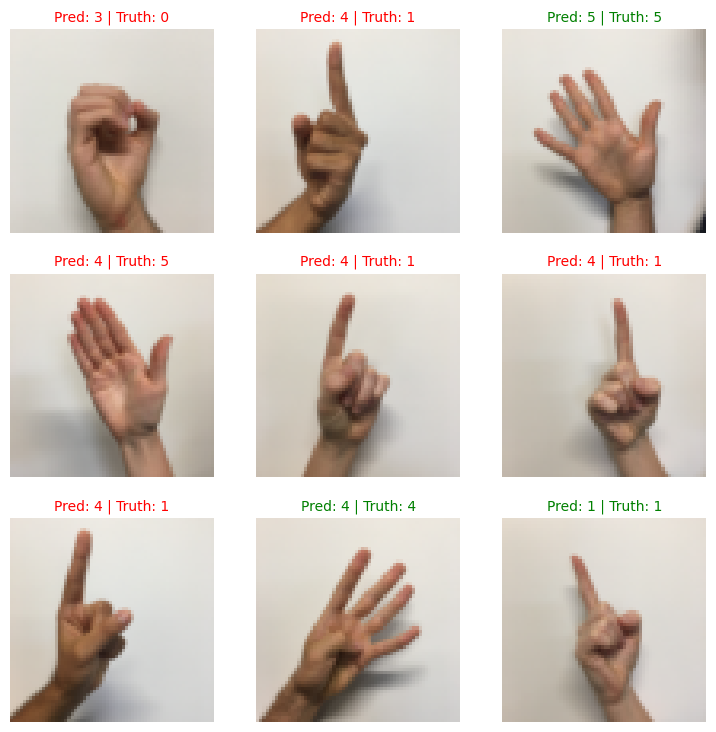

In [19]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  sample = sample.swapaxes(0, 1)
  sample = sample.swapaxes(1, 2)
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = pred_classes[i]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = test_labels[i]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

**Congratulations** on finishing this assignment! You've now implemented a state-of-the-art image classification system! Woo hoo!

ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. Hopefully, from this point, you can use what you've learned and apply it to your own classification problem to perform state-of-the-art accuracy.

<font color = 'blue'>

**What you should remember**:

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.  
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function.
- There are two main types of blocks: The **identity block** and the **convolutional block**.
- Very deep Residual Networks are built by stacking these blocks together.

<a name='5'></a>  
## 5 - Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet:

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
